In [22]:
import pandas as pd
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [5]:
nee_data = pd.read_csv('./smapSatelite/nee_mean.csv',header=None)
rh_data = pd.read_csv('./smapSatelite/rh_mean.csv',header=None)
gpp_data = pd.read_csv('./smapSatelite/gpp_mean.csv',header=None)
modis = pd.read_csv('./DadosNPPSatelite/filtered_scaled_Npp_500m.csv',header=None)

In [6]:
def dateindex(df):
    df[0] = df[0].str.extract(r'(?:[^_]*_){4}(.*?)(?=T)')
    df = df.drop([1,2,3,4],axis=1)
    df.index = df[0].apply(lambda x: datetime.strptime(x,"%Y%m%d"))
    df = df.drop(0,axis=1)
    return df
rh_data = dateindex(rh_data)
nee_data = dateindex(nee_data)
gpp_data = dateindex(gpp_data)

In [7]:
def modis_npp(modis_data):
    
    modis_data = modis_data.drop([0,1,3,4],axis=1).reset_index().drop('index',axis=1) # Retirando colunas com informações não relevantes e restabelecendo o dataframe a partir de um index 0 nas 2 linhas
    
    modis_data.columns = range(len(modis_data.columns.to_list())) # Reiniciando o index a partir do 0 para as colunas 
    
    modis_data[0] = modis_data[0].apply(lambda x:x[1:5])
    
    modis_data.set_index(0,inplace=True) # Colocando o "Acquisition Date [ A (YYYYDDD) ]"  como index para legibilidade do dataframe
    
    modis_npp_mean = modis_data.mean(axis=1) # Média de NPP nesses anos 
    
    return modis_npp_mean

modis_npp_mean = modis_npp(modis)

In [8]:
modis_2015_2022 = modis_npp_mean['2015':'2022']
nee_data = nee_data.resample('Y').mean()
rh_data = rh_data.resample('Y').mean()
gpp_data = gpp_data.resample('Y').mean()

In [9]:
nee_mean = nee_data[9]
rh_mean = rh_data[9]
npp_calculado = (nee_mean + rh_mean)
npp_calculado = npp_calculado[:'2022']

In [10]:
nee_mean = nee_mean[:'2022']

In [11]:
gpp_mean = gpp_data[9]
npp_calculado2 = (gpp_mean - rh_mean)
npp_calculado2 = npp_calculado2[:'2022']

In [12]:
rh_mean

0
2015-12-31    2.856033
2016-12-31    3.538791
2017-12-31    3.311256
2018-12-31    3.556850
2019-12-31    3.359895
2020-12-31    3.461961
2021-12-31    3.607903
2022-12-31    3.490853
2023-12-31    3.790997
Freq: A-DEC, Name: 9, dtype: float64

In [13]:
npp_calculado2.values

array([5.27816885, 4.50998502, 4.43572754, 4.41338228, 4.96288751,
       5.08082454, 4.77673782, 4.71610572])

In [14]:
df = pd.DataFrame(index=pd.date_range(start='2015-01-01', end='2022-12-31', freq='A-DEC'))
df['NPP Calculado (NEE + RH)'] = npp_calculado.values
df['MODIS'] = modis_2015_2022.values
df['NPP Calculado (GPP - RH)'] = npp_calculado2.values
df['NPP Calculado (-NEE)'] = (nee_mean.values) * -1

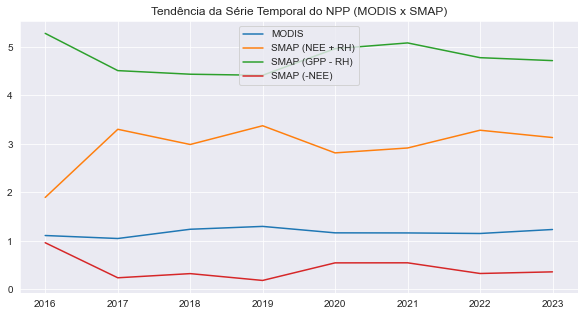

In [23]:
sns.set_style('darkgrid')

npp_calculado_decomponsicao = seasonal_decompose(df['NPP Calculado (NEE + RH)'])
modis_2015_2022_decomponsicao = seasonal_decompose(df['MODIS'])
npp_calculado2_decomponsicao = seasonal_decompose(df['NPP Calculado (GPP - RH)'])
npp_calculado3_decomponsicao = seasonal_decompose(df['NPP Calculado (-NEE)'])

plt.figure(figsize=(10,5))
plt.plot(modis_2015_2022_decomponsicao.trend)
plt.plot(npp_calculado_decomponsicao.trend)
plt.plot(npp_calculado2_decomponsicao.trend)
plt.plot(npp_calculado3_decomponsicao.trend)
plt.title("Tendência da Série Temporal do NPP (MODIS x SMAP)")
plt.legend(['MODIS','SMAP (NEE + RH)','SMAP (GPP - RH)','SMAP (-NEE)'],loc='upper center').set_visible(True)

In [44]:
def reg_graph_subplot(x, y, data, sct_size=None, s=10, title='', legend_visibility=True, legend_title='', xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False, reg_from_start=False, offset_txt_x=0.15, offset_txt_y=2.25, num_rows=1, num_cols=1, subplot_num=1, axes=None):
    # x = eixo x do gráfico
    # y = eixo y do gráfico
    # data = dataframe origem dos dados que representam x e y
    # sct_size = tamanho do scatter no gráfico BASEADO em uma coluna do dataframe
    # s = tamanho do scatter no gráfico BASEADO em um NUMERO
    # title = título do gráfico
    # legend_visibility = visibilidade da legenda
    # legend_title = título da legenda
    # xlabel = título do eixo x
    # ylabel = titulo do eixo y
    # offset_txt_x = deslocamento do texto da função no eixo x
    # offset_txt_y = deslocamento do texto da função no eixo y
    # num_rows = número de linhas de subplots
    # num_cols = número de colunas de subplots
    # subplot_num = número do subplot atual
    # axes = array de eixos para os subplots

    sns.set_style('darkgrid')

    if axes is None:
        f, ax = plt.subplots(num_rows, num_cols, figsize=(12, 5))
        ax = ax.flatten()
        ax = ax[subplot_num - 1]
    else:
        ax = axes[subplot_num - 1]

    sns.scatterplot(x=data[x], y=data[y], data=data, size=sct_size, s=s, ax=ax)

    rng = np.random.default_rng(1234)  # seed para valores aleatórios
    lr = LinearRegression(fit_intercept=fit_intercept)
    fitted_reg = lr.fit(data[[x]], data[[y]])

    if not fit_intercept:
        fitted_reg.intercept_ = [fitted_reg.intercept_]  # Prevenindo erros

    r2_score = fitted_reg.score(data[[x]], data[[y]])  # R² Score
    x_reg_line = rng.uniform(data[x].min(), data[x].max(), size=100)  # gerando valores entre os valores do scatterplot para criar a reta
    y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0]  # função y=ax + b para representar a reta criada

    if reg_from_start:

        if (data[x].min() < 0) and (abs(data[x].min()) > data[y].max()):  # Para valores data[x] negativos

            x_reg_line = rng.uniform(data[x].min() * 2, 0.0, size=10000)  # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[y].min() < 0) and (abs(data[y].min()) > data[x].max()):  # Para valores data[y] negativos

            x_reg_line = rng.uniform(data[y].min() * 2, 0.0, size=10000)  # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[x].max() > data[y].max()):

            x_reg_line = rng.uniform(0.0, data[x].max() * 2, size=10000)

        else:

            x_reg_line = rng.uniform(0.0, data[y].max() * 2, size=10000)

        y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0]  # função y=ax + b para representar a reta criada

    text_coord_x = data[x].max() - data[x].max() * offset_txt_x  # eixo x do texto

    ax.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0], 4)}x + {round(fitted_reg.intercept_[0], 4)}',
            fontsize=12, ha='center', va='center', color='blue')  # Texto da reta Azul
    ax.text(text_coord_x, offset_txt_y - (offset_txt_y * 0.3), f'R²:{round(r2_score, 4)}', fontsize=12, ha='center',
            va='center', color='blue')  # Texto r²

    ax.set_ylim((0, (data[y].max() + (data[y].max() / 2))))  # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + data[x].max() / 2))  # tamanho limite do plot no eixo x
    ax.plot(x_reg_line, y_reg_line[0])  # reta de regressão

    if ativar_grafico_yx:
        y_x = np.linspace(0, 1000, 1000)  # Gera 1000 valores igualmente espaçados entre min_x e max_x
        ax.plot(y_x, y_x,'k')  # reta y=x


    if legend_title:
        ax.legend(title=legend_title, loc='upper left').set_visible(legend_visibility)  # legenda no canto superior esquerdo

    ax.set_title(title)  # Título do gráfico
    ax.set_xlabel(xlabel)  # Título do eixo X
    ax.set_ylabel(ylabel)  # Título do eixo y

    return ax

<AxesSubplot:title={'center':'Correlação entre NPP MODIS com NPP SMAP (-NEE) [2015 ~ 2022]'}, xlabel='NPP Calculado (SMAP)', ylabel='NPP (Modis)'>

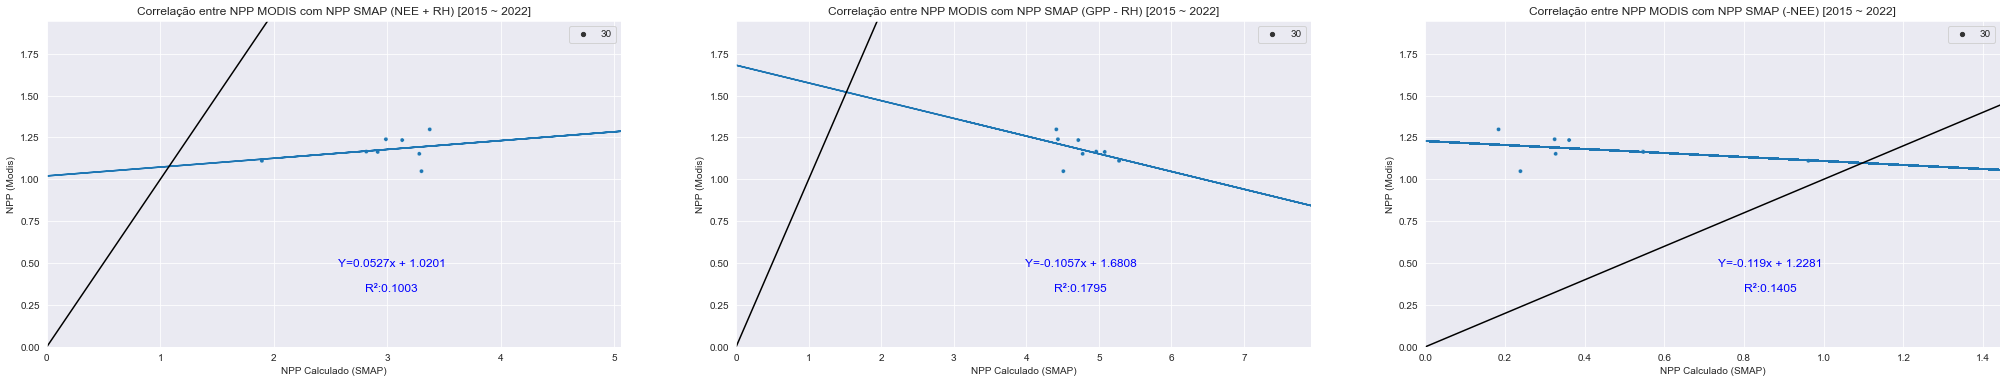

In [50]:
#(x, y, data,sct_size=10, title='', legend_visibility=True, legend_title=None, xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25)
fig, ax = plt.subplots(1, 3, figsize=(35, 6))


eixo_x = 'NPP Calculado (NEE + RH)'
eixo_x2 ='NPP Calculado (GPP - RH)'
eixo_x3 = 'NPP Calculado (-NEE)'

eixo_y = 'MODIS'

title = 'Correlação entre NPP MODIS com NPP SMAP (NEE + RH) [2015 ~ 2022]'
title2 = 'Correlação entre NPP MODIS com NPP SMAP (GPP - RH) [2015 ~ 2022]'
title3 = 'Correlação entre NPP MODIS com NPP SMAP (-NEE) [2015 ~ 2022]'

xlabel = 'NPP Calculado (SMAP)'
ylabel = 'NPP (Modis)'


reg_graph_subplot(eixo_x,eixo_y,sct_size=30,data=df,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.1,offset_txt_y=0.5,axes=ax, subplot_num=1,ativar_grafico_yx=True)
reg_graph_subplot(eixo_x2,eixo_y,sct_size=30,data=df,xlabel=xlabel,ylabel=ylabel,title=title2,legend_visibility=False,reg_from_start=True,offset_txt_x=0.1,offset_txt_y=0.5,axes=ax, subplot_num=2,ativar_grafico_yx=True)
reg_graph_subplot(eixo_x3,eixo_y,sct_size=30,data=df,xlabel=xlabel,ylabel=ylabel,title=title3,legend_visibility=False,reg_from_start=True,offset_txt_x=0.1,offset_txt_y=0.5,axes=ax, subplot_num=3,ativar_grafico_yx=True)

<AxesSubplot:>

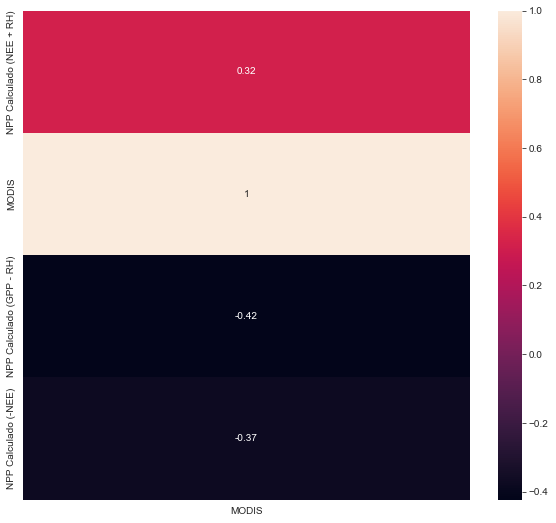

In [52]:
plt.figure(figsize=(10,9))
sns.heatmap(df.corr()['MODIS'].to_frame(),annot=True)